In [5]:
import torch
from dataset import collate_fn, get_dataset, get_dataset_train, get_dataset_valid
from torch import nn
from torch.utils.data import DataLoader
from model import get_model, clip_loss
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_score
import pandas as pd

In [6]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="../data/checkpoints/clip-model",
    num_train_epochs=50,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=1,
    warmup_steps=50,
    learning_rate=1e-5,
    weight_decay=0.01,
    logging_steps=10,
    save_strategy="epoch",
    optim="adamw_torch_fused",
    bf16=True if torch.cuda.is_available() else False,
    report_to="none",
    dataloader_num_workers=6,
)


In [34]:
def compute_sims(model, ds, device="cpu"):
    model.eval()
    all_image_embs = []
    all_texts = []

    with torch.no_grad():
        for imgs, texts in ds:
            imgs = imgs.to(device).unsqueeze(0)
            all_image_embs.append(model.project_images(imgs))
            all_texts.append(texts)  # mantém lista de strings

        # concatena embeddings de todas as imagens
        image_embs = torch.cat(all_image_embs, dim=0)  # (num_images, dim)

        # codifica todos os textos
        text_embs = model.project_texts(all_texts).to(device)  # (num_texts, dim)

        # matriz de similaridade coseno
        sims = torch.matmul(image_embs, text_embs.T)  # (num_images, num_texts)

    return sims

@torch.no_grad()
def compute_silhouette(model, ds, device):
    # Calcula o índice de silhueta com base nas similaridades

    # Similaridade entre imagens e textos
    sims = compute_sims(model, ds, device)  # (num_images, num_texts)

    # Converte similaridade -> distância exponencial
    dist = torch.exp(-sims.detach().cpu())

    # Normaliza [0, 1] antes do cálculo da silhueta
    dist = (dist - dist.min()) / (dist.max() - dist.min())

    # Inicializa a diagonal principal com zeros
    idx = torch.arange(dist.size(0))
    dist[idx, idx] = 0

    # cria rótulos
    n = dist.shape[0]
    
    if n == 4056:
        # proporções conhecidas: [56, 1000, 1000, 1000, 1000]
        proporcoes = np.array([56, 1000, 1000, 1000, 1000])
    elif n == 1014:
        # proporções conhecidas: [14, 250, 250, 250, 250]
        proporcoes = np.array([14, 250, 250, 250, 250])
    else:
        # fallback genérico: 5 partes iguais
        proporcoes = np.ones(5)

    sizes = proporcoes
    sizes[-1] = n - sizes[:-1].sum()  # corrige arredondamento

    split_indices = np.split(np.arange(n), np.cumsum(sizes)[:-1])
    labels = np.zeros(n, dtype=int)
    for i, idxs in enumerate(split_indices):
        labels[idxs] = i

    # Calcula índice de silhueta
    score = silhouette_score(dist, labels, metric="precomputed")

    return score, labels

In [9]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


# Configurações
device = "cuda" if torch.cuda.is_available() else "cpu"
model = get_model()
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
metrics = []

ds_train = get_dataset_train("../Graphs/watts-strogatz-train/images", "../Graphs/watts-strogatz-train/edgelists.json", split=0)
ds_valid = get_dataset_valid("../Graphs/watts-strogatz-valid/images", "../Graphs/watts-strogatz-valid/edgelists.json", split=0)

dl_train = torch.utils.data.DataLoader(ds_train,
                                 batch_size=training_args.per_device_train_batch_size,
                                 shuffle=True,
                                 num_workers=training_args.dataloader_num_workers, 
                                 collate_fn=collate_fn,)

dl_valid = torch.utils.data.DataLoader(ds_valid,
                                    batch_size=training_args.per_device_train_batch_size,
                                    shuffle=False,
                                    num_workers=training_args.dataloader_num_workers, 
                                    collate_fn=collate_fn,)

optimizer = torch.optim.AdamW(model.parameters(),
                              lr=training_args.learning_rate,
                              weight_decay=training_args.weight_decay)

model.to(device)

train_losses = []
train_sils = []

valid_losses = []
valid_sils = []

for epoch in range(int(training_args.num_train_epochs)):
    total_loss_train = 0
    model.train()
    for step, (imgs, texts) in enumerate(dl_train):
        imgs = imgs.to(device)

        # Tokeniza os textos do batch
        enc_texts = tokenizer(
            list(texts), padding=True, truncation=True, return_tensors="pt"
        ).to(device)

        optimizer.zero_grad()

        # logits = (batch_img, batch_text) → matriz (B, B)
        logits = model(imgs, list(texts))

        # CLIP loss (InfoNCE)
        loss = clip_loss(logits)
        loss.backward()

        # grad accumulation
        if (step + 1) % training_args.gradient_accumulation_steps == 0:
            optimizer.step()

        total_loss_train += loss.item()

    with torch.no_grad():
        total_loss_valid = 0
        model.eval()
        for step, (imgs, texts) in enumerate(dl_valid):
        
            imgs = imgs.to(device)

            # Tokeniza os textos do batch
            enc_texts = tokenizer(
                list(texts), padding=True, truncation=True, return_tensors="pt"
            ).to(device)

            # logits = (batch_img, batch_text) → matriz (B, B)
            logits = model(imgs, list(texts))

            # CLIP loss (InfoNCE)
            loss = clip_loss(logits)

            total_loss_valid += loss.item()

    # logging
    avg_loss_train = total_loss_train / len(dl_train)
    avg_loss_valid = total_loss_valid / len(dl_valid)
    sil_score_train = compute_silhouette(model, ds_train, device=device)
    sil_score_valid = compute_silhouette(model, ds_valid, device=device)

    train_losses.append(avg_loss_train)
    train_sils.append(sil_score_train)
    valid_losses.append(avg_loss_valid)
    valid_sils.append(sil_score_valid)

    metrics.append([epoch, avg_loss_train, avg_loss_valid, sil_score_train, sil_score_valid])
    #metrics.append([epoch, avg_loss_train, avg_loss_valid])


    epoch_str = f"Epoch {epoch+1}/{training_args.num_train_epochs}"

    print("\t\tLoss Treinamento\tLoss Validacao\tSilhueta Treinamento\tSilhueta Validacao")
    #print("\t\tLoss Treinamento\tLoss Validacao")

    print(f"{epoch_str}\t{avg_loss_train:.4f}\t\t\t{avg_loss_valid:.4f}\t\t{sil_score_train:.4f}\t\t\t{sil_score_valid:.4f}")
    #print(f"{epoch_str}\t{avg_loss_train:.4f}\t\t\t{avg_loss_valid:.4f}")

df_metrics = pd.DataFrame(metrics, columns=['epoca', 'loss_train', 'loss_valid', 'sil_train', 'sil_valid'])
#df_metrics = pd.DataFrame(metrics, columns=['epoca', 'loss_train', 'loss_valid'])
df_metrics.to_csv("Metricas Treinamento-Validacao-Watts-Strogatz-Dataset-Dividido-50epoch.csv")

torch.save(model.state_dict(), "Modelo-Watts-Strogatz-Dataset-Dividido-50epoch.ckpt")

Device set to use cpu


		Loss Treinamento	Loss Validacao	Silhueta Treinamento	Silhueta Validacao
Epoch 1/50	2.1026			2.0880		-0.0014			-0.0039
		Loss Treinamento	Loss Validacao	Silhueta Treinamento	Silhueta Validacao
Epoch 2/50	2.0823			2.0814		-0.0008			-0.0063
		Loss Treinamento	Loss Validacao	Silhueta Treinamento	Silhueta Validacao
Epoch 3/50	2.0656			2.0774		-0.0017			-0.0082
		Loss Treinamento	Loss Validacao	Silhueta Treinamento	Silhueta Validacao
Epoch 4/50	2.0303			2.0739		-0.0091			-0.0076
		Loss Treinamento	Loss Validacao	Silhueta Treinamento	Silhueta Validacao
Epoch 5/50	1.9627			2.0664		-0.0213			-0.0036
		Loss Treinamento	Loss Validacao	Silhueta Treinamento	Silhueta Validacao
Epoch 6/50	1.8812			2.0605		-0.0436			-0.0144
		Loss Treinamento	Loss Validacao	Silhueta Treinamento	Silhueta Validacao
Epoch 7/50	1.8329			2.0324		-0.0412			-0.0239
		Loss Treinamento	Loss Validacao	Silhueta Treinamento	Silhueta Validacao
Epoch 8/50	1.8000			1.9870		-0.0128			-0.0203
		Loss Treinamento	Loss Validacao	Silhue

In [10]:
torch.save(model.state_dict(), "Modelo-Watts-Strogatz-Dataset-Dividido-50epoch.ckpt")

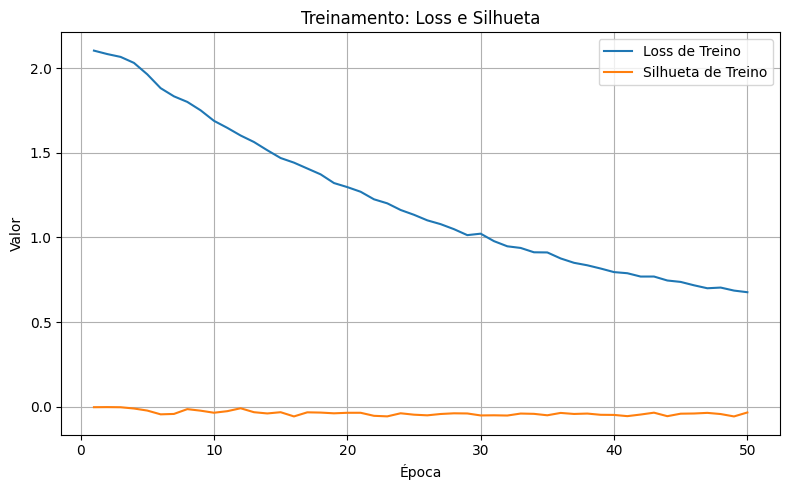

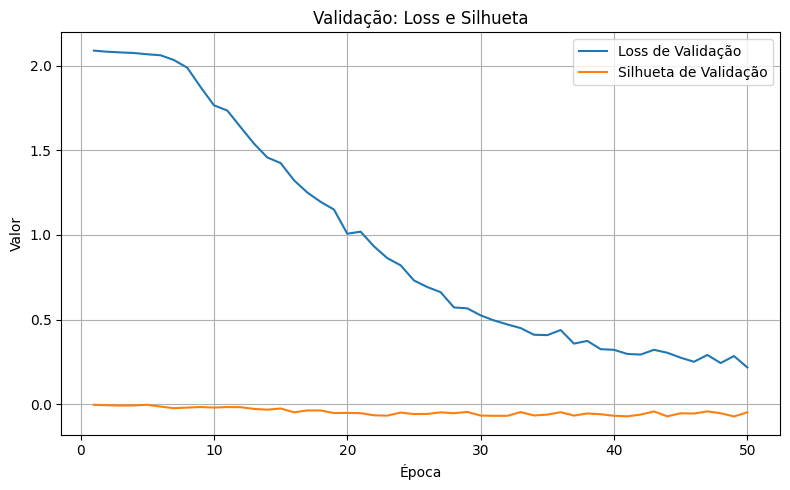

In [19]:
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(8, 5))
plt.title("Treinamento: Loss e Silhueta")
plt.plot(epochs, train_losses, label="Loss de Treino", color="tab:blue")
plt.plot(epochs, train_sils, label="Silhueta de Treino", color="tab:orange")
plt.xlabel("Época")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.title("Validação: Loss e Silhueta")
plt.plot(epochs, valid_losses, label="Loss de Validação", color="tab:blue")
plt.plot(epochs, valid_sils, label="Silhueta de Validação", color="tab:orange")
plt.xlabel("Época")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
len(ds_train)

4056

In [12]:
# Calcula similaridades
sims_train = compute_sims(model, ds_train, device=device)
sims_valid = compute_sims(model, ds_valid, device=device)

In [13]:
# Histograma comparando cada rewire com todos os outros textos - treino
sims_rewire1_train = sims_train[:56].reshape(-1)
sims_rewire2_train = sims_train[57:1056].reshape(-1)
sims_rewire3_train = sims_train[1057:2056].reshape(-1)
sims_rewire6_train = sims_train[2057:3056].reshape(-1)
sims_rewire10_train = sims_train[3057:4056].reshape(-1)

# Histograma comparando cada rewire com todos os outros textos - treino
sims_rewire1_valid = sims_valid[:14].reshape(-1)
sims_rewire2_valid = sims_valid[15:264].reshape(-1)
sims_rewire3_valid = sims_valid[265:514].reshape(-1)
sims_rewire6_valid = sims_valid[515:764].reshape(-1)
sims_rewire10_valid = sims_valid[765:1014].reshape(-1)

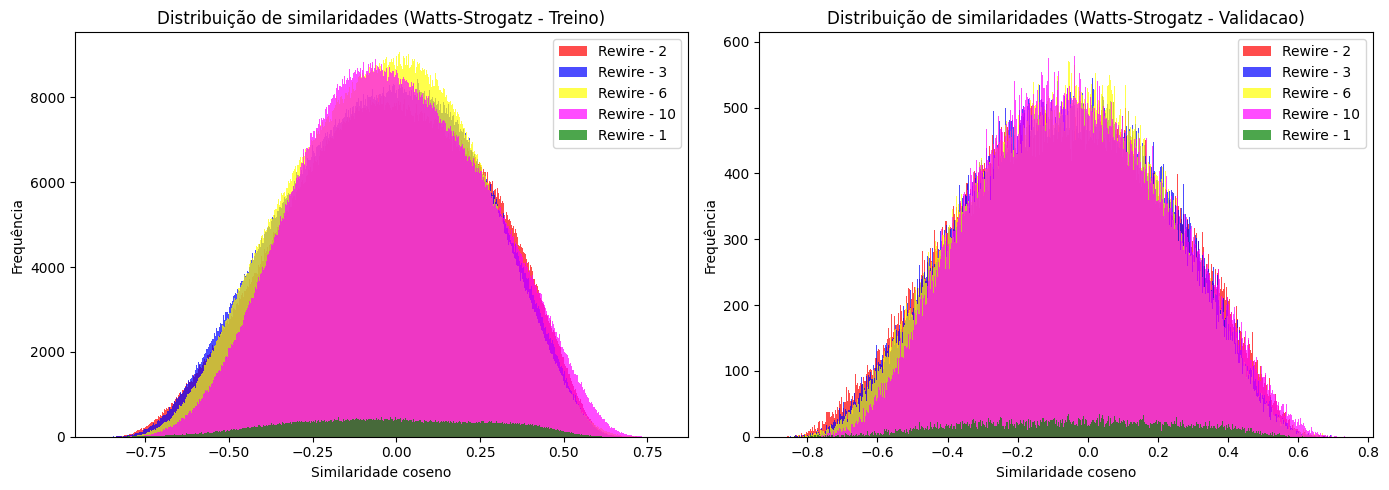

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma 1000 vs 1000
axes[0].hist(sims_rewire2_train.cpu().numpy(), bins=1000, alpha=0.7, color="red", label="Rewire - 2")
axes[0].hist(sims_rewire3_train.cpu().numpy(), bins=1000, alpha=0.7, color="blue", label="Rewire - 3")
axes[0].hist(sims_rewire6_train.cpu().numpy(), bins=1000, alpha=0.7, color="yellow", label="Rewire - 6")
axes[0].hist(sims_rewire10_train.cpu().numpy(), bins=1000, alpha=0.7, color="magenta", label="Rewire - 10")
axes[0].hist(sims_rewire1_train.cpu().numpy(), bins=1000, alpha=0.7, color="green", label="Rewire - 1")

axes[0].set_title("Distribuição de similaridades (Watts-Strogatz - Treino)")
axes[0].set_xlabel("Similaridade coseno")
axes[0].set_ylabel("Frequência")
axes[0].legend()

# Histograma 250 vs 250
axes[1].hist(sims_rewire2_valid.cpu().numpy(), bins=1000, alpha=0.7, color="red", label="Rewire - 2")
axes[1].hist(sims_rewire3_valid.cpu().numpy(), bins=1000, alpha=0.7, color="blue", label="Rewire - 3")
axes[1].hist(sims_rewire6_valid.cpu().numpy(), bins=1000, alpha=0.7, color="yellow", label="Rewire - 6")
axes[1].hist(sims_rewire10_valid.cpu().numpy(), bins=1000, alpha=0.7, color="magenta", label="Rewire - 10")
axes[1].hist(sims_rewire1_valid.cpu().numpy(), bins=1000, alpha=0.7, color="green", label="Rewire - 1")

axes[1].set_title("Distribuição de similaridades (Watts-Strogatz - Validacao)")
axes[1].set_xlabel("Similaridade coseno")
axes[1].set_ylabel("Frequência")
axes[1].legend()

plt.tight_layout()
plt.show()

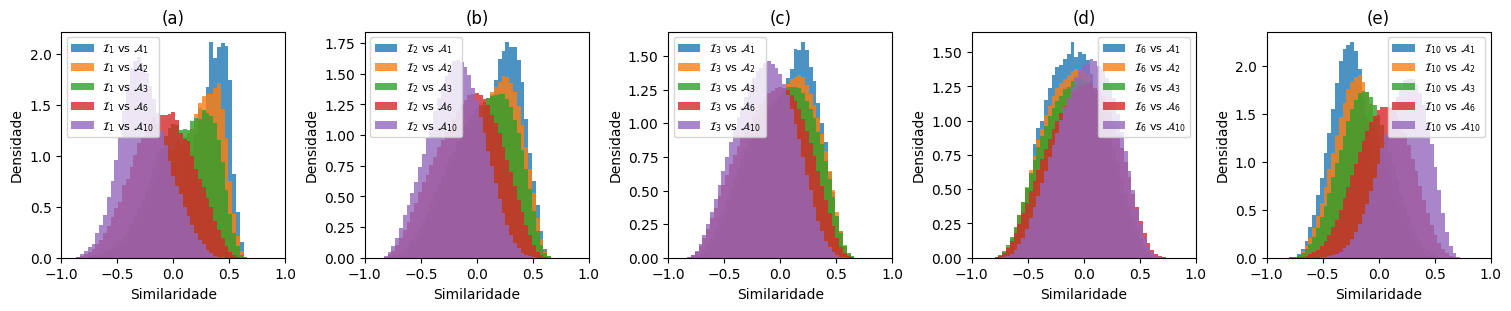

In [44]:
def create_histograms(sim_mat, num_items_per_class, class_names, xlim=(-1, 1)):
    """ Plota histogramas das similaridades entre classes.
    Args:
        sim_mat: Matriz de similaridade.
        num_items_per_class: Número de itens por classe.
        class_names: Nomes das classes.
        xlim: Limites do eixo x.
    """

    num_classes = len(num_items_per_class)

    num_items_per_class = torch.tensor([0] + num_items_per_class)
    class_indices = torch.cumsum(num_items_per_class, dim=0)

    bins = torch.linspace(-1, 1, 60)

    fig, axs = plt.subplots(1, num_classes, figsize=(15, 3), constrained_layout=True)
    for i_ref, c_ref in enumerate(range(num_classes)):
        for i_cmp, c_cmp in enumerate(range(num_classes)):
            slice_ref = slice(class_indices[c_ref], class_indices[c_ref + 1])
            slice_cmp = slice(class_indices[c_cmp], class_indices[c_cmp + 1])
            block = sim_mat[slice_ref, slice_cmp]

            label = f'$\\mathcal{{I}}_{{{class_names[c_ref]}}}$ vs $\\mathcal{{A}}_{{{class_names[c_cmp]}}}$'
            ax = axs[i_ref]
            ax.hist(block.cpu().flatten(), bins=bins, density=True, label=label, alpha=0.8)
            ax.set_xlabel("Similaridade")
            ax.set_ylabel("Densidade")
            ax.set_title(f"({chr(97 + i_ref)})")
        ax.set_xlim(xlim)
        ax.legend(fontsize=8)

# Número de elementos para cada classe
num_items_per_class = [56, 1000, 1000, 1000, 1000] # treinamento
#num_items_per_class = [14, 200, 200, 200, 200]   # validação
class_names = ["1", "2", "3", "6", "10"]
create_histograms(sims_train, num_items_per_class, class_names, xlim=(-1.0, 1))


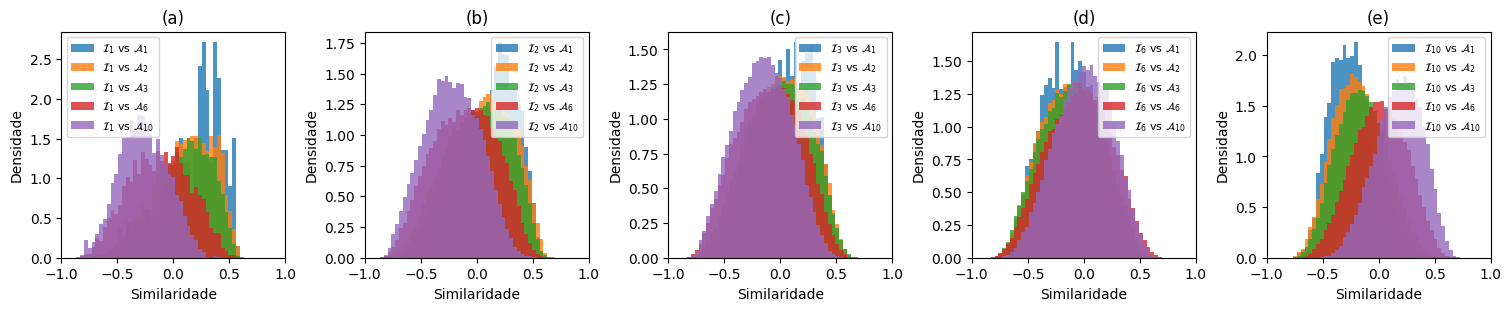

In [45]:
num_items_per_class = [14, 250, 250, 250, 250]   # validação
create_histograms(sims_valid, num_items_per_class, class_names, xlim=(-1.0, 1))

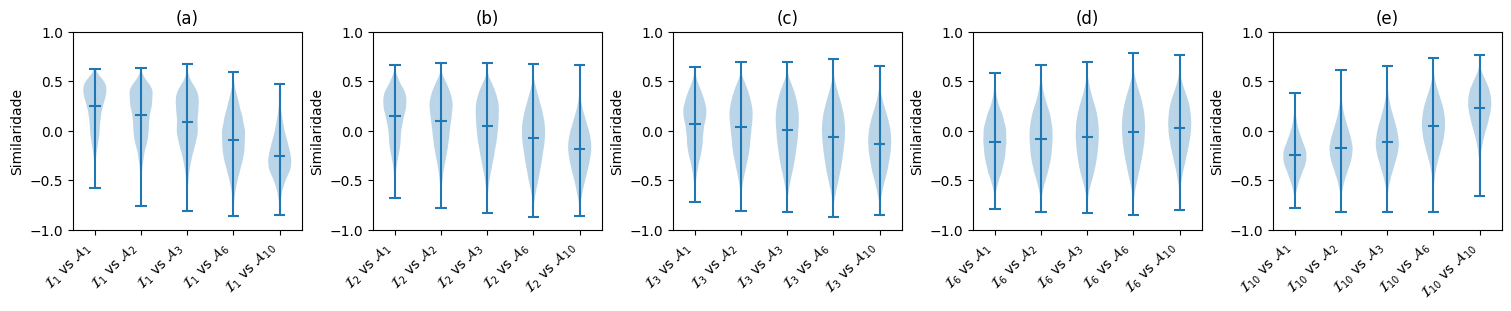

In [37]:
def create_violin_plots(sim_mat, num_items_per_class, class_names, ylim=(-1, 1)):
    """ Plota gráficos de violino das similaridades entre classes.
    Args:
        sim_mat: Matriz de similaridade.
        num_items_per_class: Número de itens por classe.
        class_names: Nomes das classes.
        ylim: Limites do eixo y.
    """

    num_classes = len(num_items_per_class)

    num_items_per_class = torch.tensor([0] + num_items_per_class)
    class_indices = torch.cumsum(num_items_per_class, dim=0)

    fig, axs = plt.subplots(1, num_classes, figsize=(15, 3), constrained_layout=True)
    for i_ref, c_ref in enumerate(range(num_classes)):
        violin_values = []
        labels = []
        for i_cmp, c_cmp in enumerate(range(num_classes)):
            slice_ref = slice(class_indices[c_ref], class_indices[c_ref + 1])
            slice_cmp = slice(class_indices[c_cmp], class_indices[c_cmp + 1])
            block = sim_mat[slice_ref, slice_cmp]
            
            violin_values.append(block.cpu().flatten().numpy())
            label = f'$\\mathcal{{I}}_{{{class_names[c_ref]}}}$ vs $\\mathcal{{A}}_{{{class_names[c_cmp]}}}$'
            labels.append(label)
            
        ax = axs[i_ref]
        ax.violinplot(violin_values, showmeans=True, points=100)
        ax.set_xticks(range(1, num_classes + 1))
        ax.set_xticklabels(labels, rotation=45, ha="right")
        ax.set_ylabel("Similaridade")
        ax.set_ylim(ylim)
        ax.set_title(f"({chr(97 + i_ref)})")

# Número de elementos para cada classe
num_items_per_class = [56, 1000, 1000, 1000, 1000]   # treinamento
class_names = ["1", "2", "3", "6", "10"]
create_violin_plots(sims_train, num_items_per_class, class_names, ylim=(-1.0, 1.0))


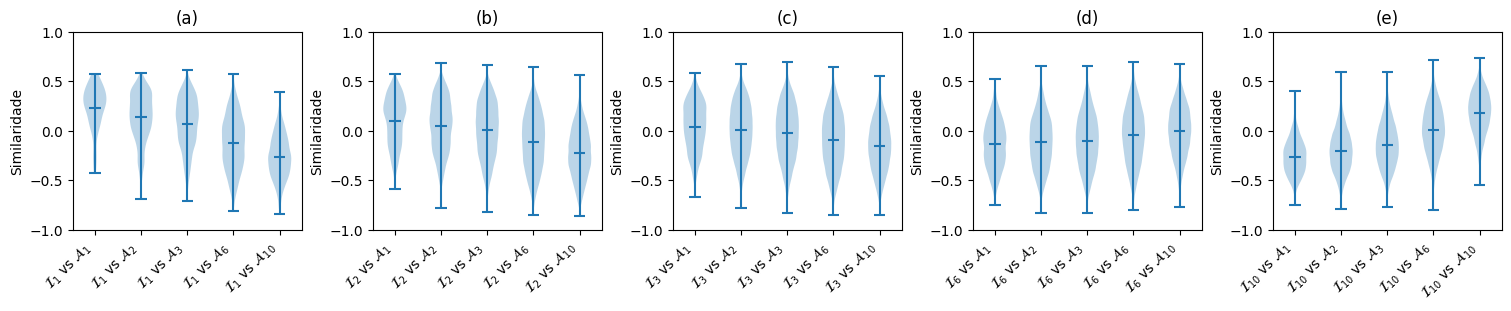

In [38]:
num_items_per_class = [14, 250, 250, 250, 250] # validacao
create_violin_plots(sims_valid, num_items_per_class, class_names, ylim=(-1.0, 1.0))

In [20]:
sims_train.shape

torch.Size([4056, 4056])

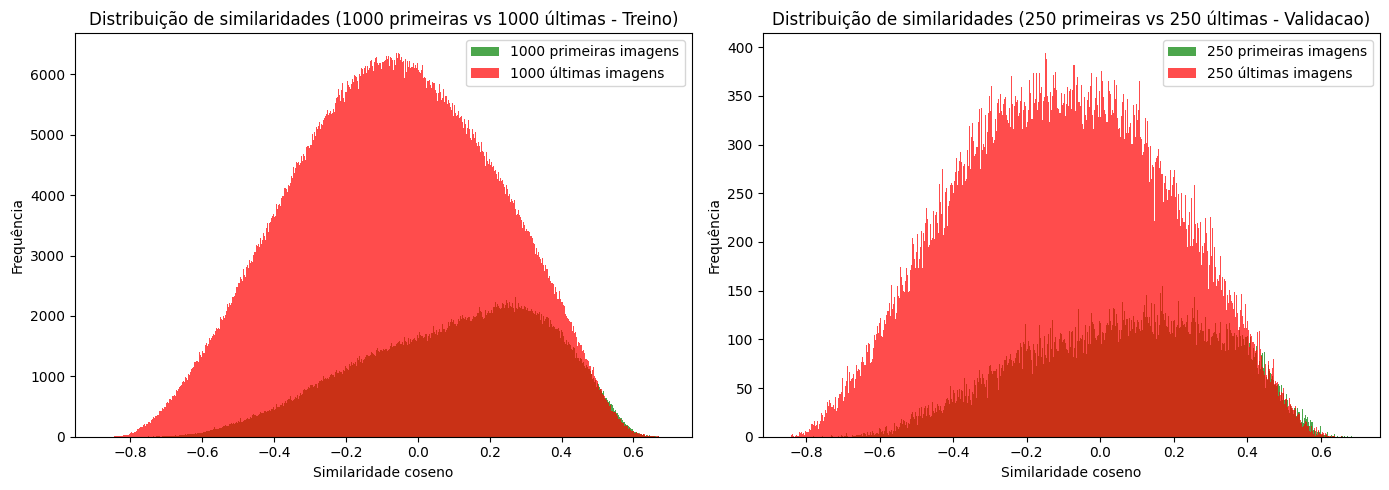

In [21]:
# Quadrante superior esquerdo x Quadrante superior direito
# [:x, :x] = Q1
# [:x, x:] = Q2
# [x:, :x] = Q3
# [x:, x:] = Q4
sims_first1000 = sims_train[:1000, :1000].reshape(-1)
sims_last1000 = sims_train[:1000, 1000:].reshape(-1)

sims_first250 = sims_valid[:250, :250].reshape(-1)
sims_last250 = sims_valid[:250, 250:].reshape(-1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma 1000 vs 1000
axes[0].hist(sims_first1000.cpu().numpy(), bins=1000, alpha=0.7, color="green", label="1000 primeiras imagens")
axes[0].hist(sims_last1000.cpu().numpy(), bins=1000, alpha=0.7, color="red", label="1000 últimas imagens")
axes[0].set_title("Distribuição de similaridades (1000 primeiras vs 1000 últimas - Treino)")
axes[0].set_xlabel("Similaridade coseno")
axes[0].set_ylabel("Frequência")
axes[0].legend()

# Histograma 250 vs 250
axes[1].hist(sims_first250.cpu().numpy(), bins=1000, alpha=0.7, color="green", label="250 primeiras imagens")
axes[1].hist(sims_last250.cpu().numpy(), bins=1000, alpha=0.7, color="red", label="250 últimas imagens")
axes[1].set_title("Distribuição de similaridades (250 primeiras vs 250 últimas - Validacao)")
axes[1].set_xlabel("Similaridade coseno")
axes[1].set_ylabel("Frequência")
axes[1].legend()

plt.tight_layout()
plt.show()

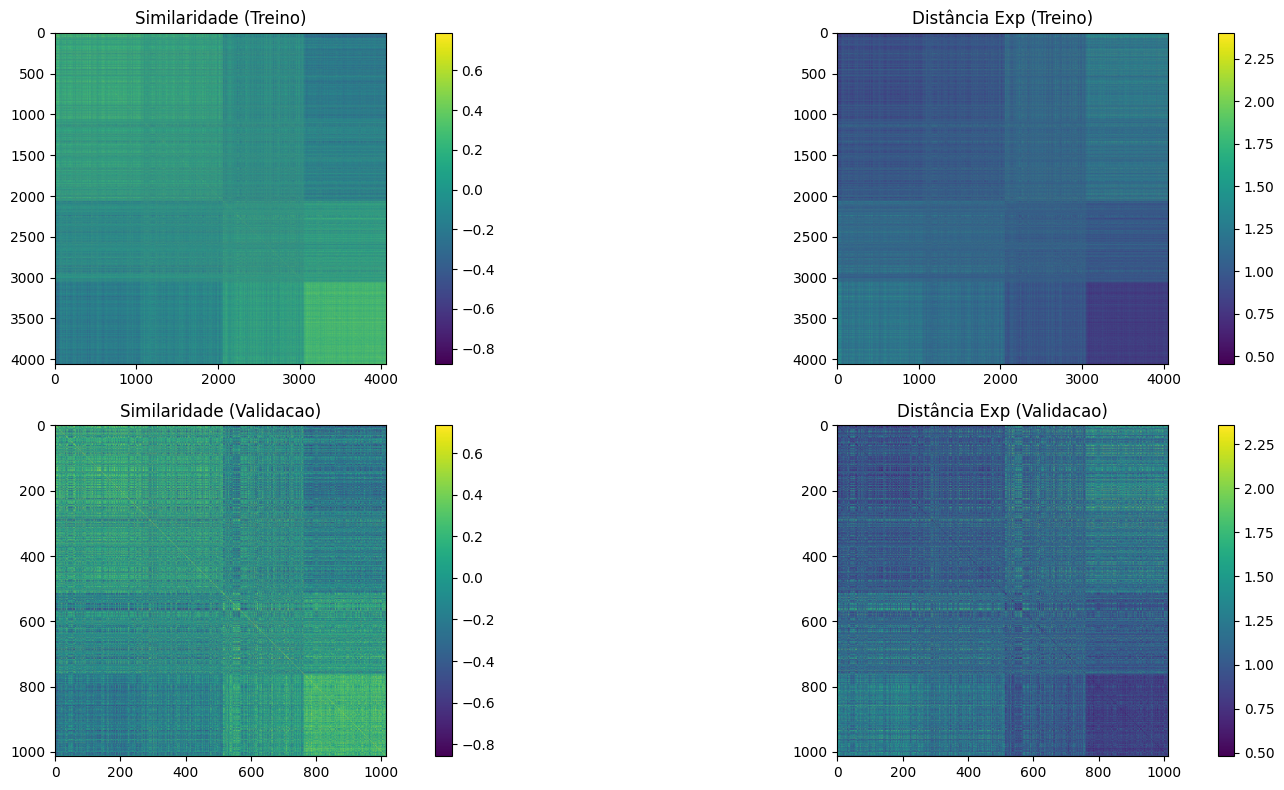

In [22]:
sims_train_matrix = sims_train.detach().cpu()
dist_train_matrix = torch.exp(-sims_train).detach().cpu()

sims_valid_matrix = sims_valid.detach().cpu()
dist_valid_matrix = torch.exp(-sims_valid).detach().cpu()

fig, axes = plt.subplots(2, 2, figsize=(18, 8))  # 2 linhas, 2 colunas
axes = axes.flatten()

# Plot da similaridade
im0 = axes[0].imshow(sims_train_matrix, cmap='viridis')
axes[0].set_title("Similaridade (Treino)")
fig.colorbar(im0, ax=axes[0])

# Plot da distância exponencial
im1 = axes[1].imshow(dist_train_matrix, cmap='viridis')
axes[1].set_title("Distância Exp (Treino)")
fig.colorbar(im1, ax=axes[1])

# Plot da similaridade
im2 = axes[2].imshow(sims_valid_matrix, cmap='viridis')
axes[2].set_title("Similaridade (Validacao)")
fig.colorbar(im2, ax=axes[2])

# Plot da distância exponencial
im3 = axes[3].imshow(dist_valid_matrix, cmap='viridis')
axes[3].set_title("Distância Exp (Validacao)")
fig.colorbar(im3, ax=axes[3])

plt.tight_layout()
plt.show()

In [46]:
from sklearn.metrics import top_k_accuracy_score

top = 1
top_k_train = top_k_accuracy_score(range(len(sims_train)), sims_train.cpu(), k=top)
top_k_valid = top_k_accuracy_score(range(len(sims_valid)), sims_valid.cpu(), k=top)

print(f"top{top} treino = {top_k_train}\ntop{top} validacao = {top_k_valid}")

top1 treino = 0.11612426035502958
top1 validacao = 0.3520710059171598


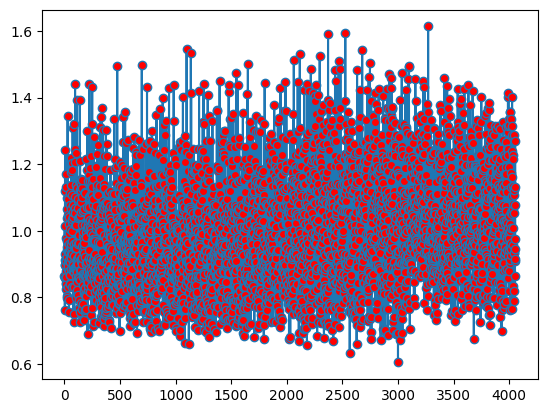

In [24]:
idx_ref = 3000
sims_img = sims_train[idx_ref]
plt.plot(torch.exp(-sims_img.cpu()), "-o", markerfacecolor="red")


In [25]:
[ds_train[idx][1] for idx in range(1990, 2000)]

['0-1 0-9 1-2 2-3 2-5 3-4 4-9 5-8 6-7 7-8',
 '0-3 0-9 1-3 1-5 2-3 4-5 5-6 6-7 7-8 8-9',
 '0-1 0-7 0-9 1-2 2-3 2-8 3-4 4-7 5-6 6-7',
 '0-1 0-7 0-9 1-2 1-3 2-6 4-5 5-6 6-7 8-9',
 '0-6 0-9 1-2 2-3 2-8 3-4 4-5 5-9 6-7 7-8',
 '0-7 0-9 1-2 2-3 2-8 3-8 4-5 5-6 6-7 7-8',
 '0-6 0-9 1-2 2-3 2-6 3-4 4-5 5-6 5-7 8-9',
 '0-8 0-9 1-2 2-3 3-4 3-8 4-5 5-6 5-7 6-7',
 '0-7 1-2 1-9 2-3 2-8 3-4 4-5 5-6 6-7 7-8',
 '0-1 1-2 1-5 2-3 3-4 4-6 5-9 6-7 7-8 8-9']

In [26]:
ds = get_dataset_train("../Graphs/watts-strogatz-train/images", "../Graphs/watts-strogatz-train/edgelists.json", split=0)
ds.ds.ids

['1_rewires_0001',
 '1_rewires_0002',
 '1_rewires_0003',
 '1_rewires_0004',
 '1_rewires_0006',
 '1_rewires_0007',
 '1_rewires_0008',
 '1_rewires_0009',
 '1_rewires_0011',
 '1_rewires_0012',
 '1_rewires_0013',
 '1_rewires_0014',
 '1_rewires_0016',
 '1_rewires_0017',
 '1_rewires_0018',
 '1_rewires_0019',
 '1_rewires_0021',
 '1_rewires_0022',
 '1_rewires_0023',
 '1_rewires_0024',
 '1_rewires_0026',
 '1_rewires_0027',
 '1_rewires_0028',
 '1_rewires_0029',
 '1_rewires_0031',
 '1_rewires_0032',
 '1_rewires_0033',
 '1_rewires_0034',
 '1_rewires_0036',
 '1_rewires_0037',
 '1_rewires_0038',
 '1_rewires_0039',
 '1_rewires_0041',
 '1_rewires_0042',
 '1_rewires_0043',
 '1_rewires_0044',
 '1_rewires_0046',
 '1_rewires_0047',
 '1_rewires_0048',
 '1_rewires_0049',
 '1_rewires_0051',
 '1_rewires_0052',
 '1_rewires_0053',
 '1_rewires_0054',
 '1_rewires_0056',
 '1_rewires_0057',
 '1_rewires_0058',
 '1_rewires_0059',
 '1_rewires_0061',
 '1_rewires_0062',
 '1_rewires_0063',
 '1_rewires_0064',
 '1_rewires_

In [27]:
len(ds)

4056

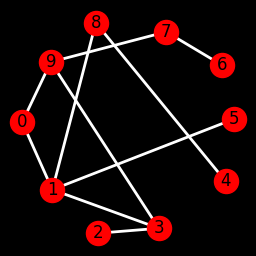

'0-1 0-9 1-3 1-5 1-8 2-3 3-9 4-8 6-7 7-9'

In [28]:
ds.transform = None
display(*ds[idx_ref])

'------rewire 1 menos similares--------'

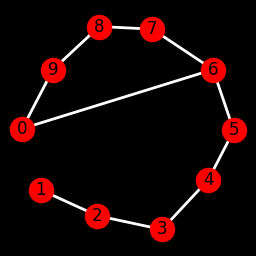

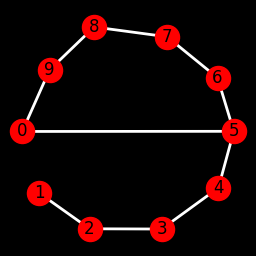

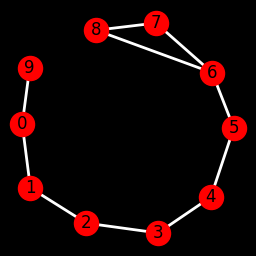

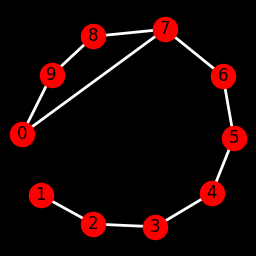

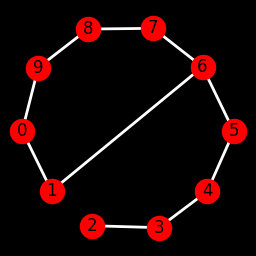

'------rewire 1 mais similares--------'

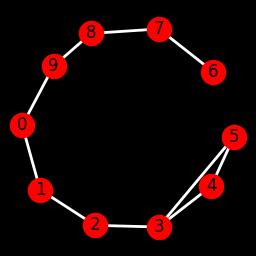

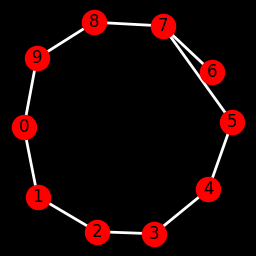

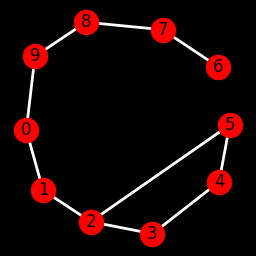

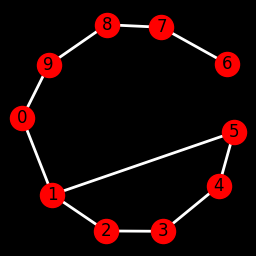

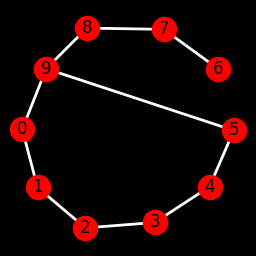

'------rewire 2 menos similares--------'

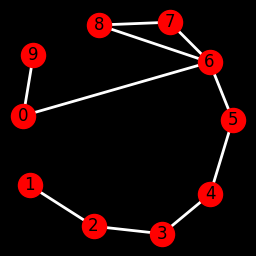

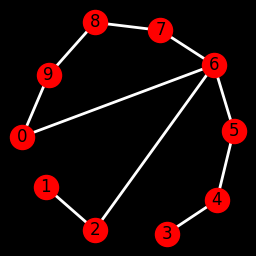

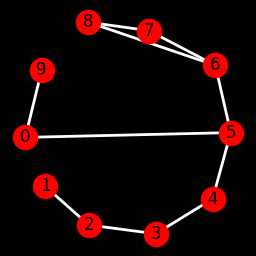

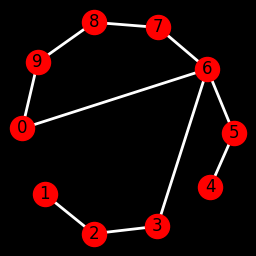

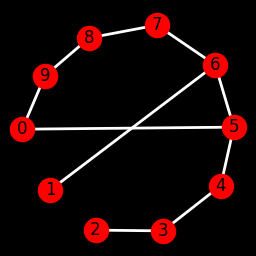

'------rewire 2 mais similares--------'

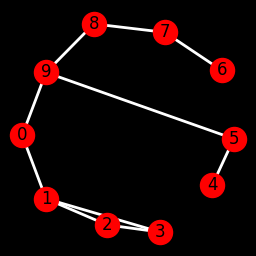

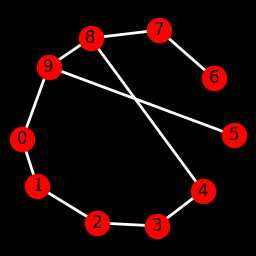

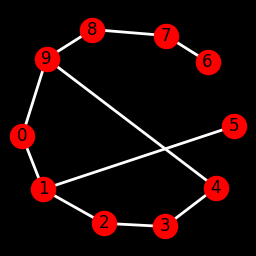

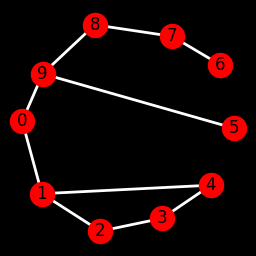

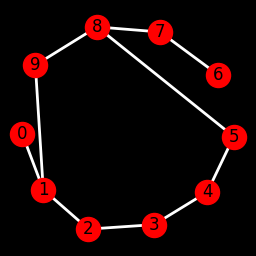

'------rewire 3 menos similares--------'

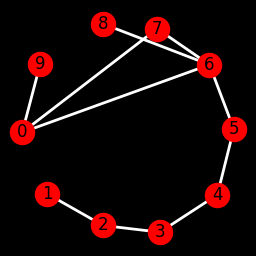

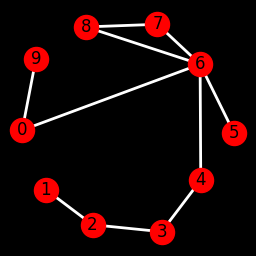

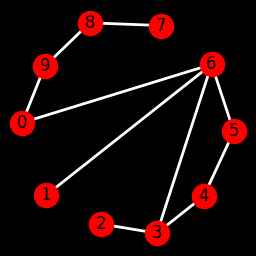

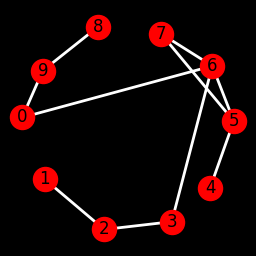

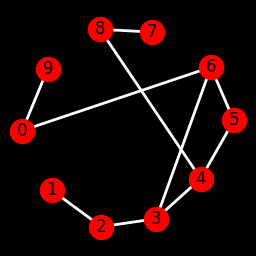

'------rewire 3 mais similares--------'

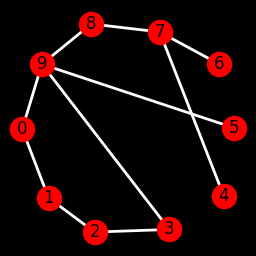

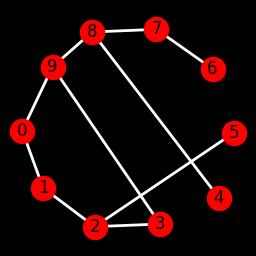

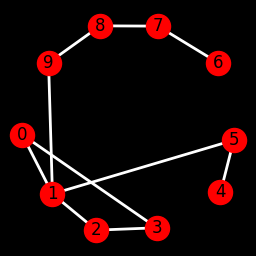

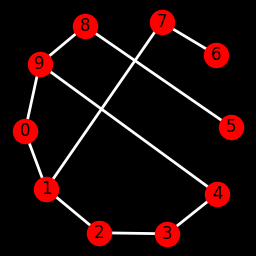

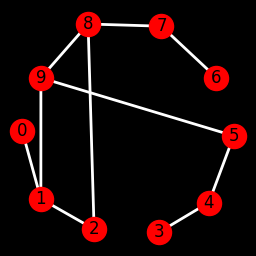

'------rewire 6 menos similares--------'

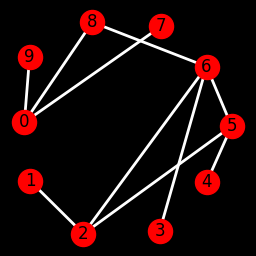

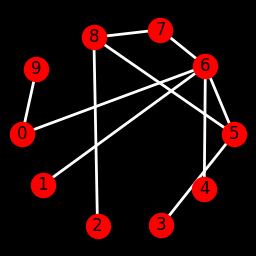

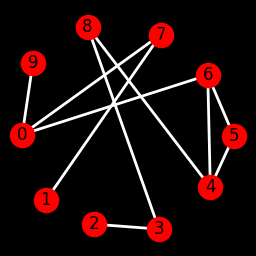

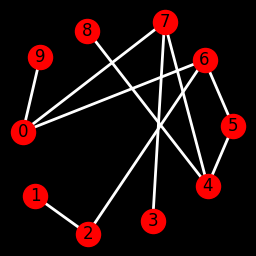

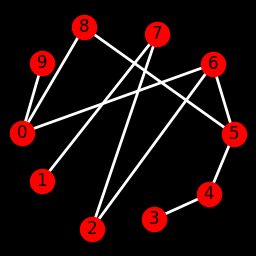

'------rewire 6 mais similares--------'

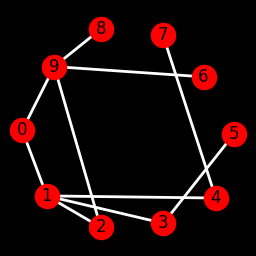

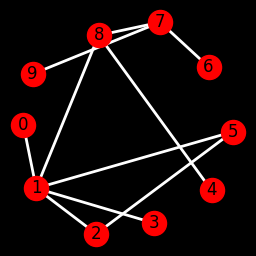

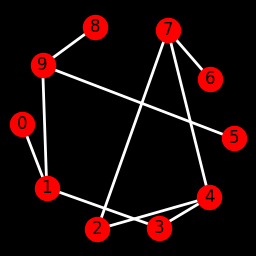

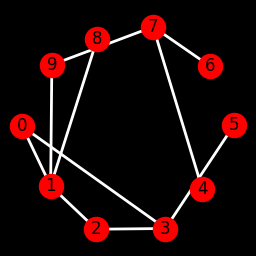

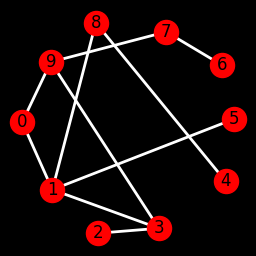

'------rewire 10 menos similares--------'

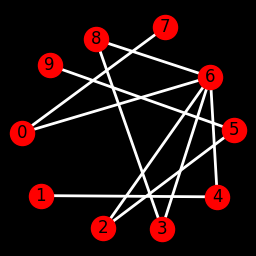

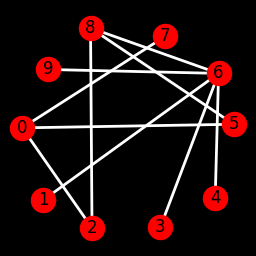

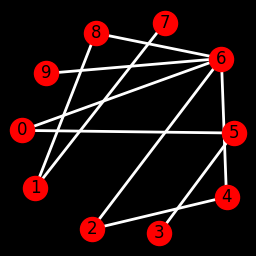

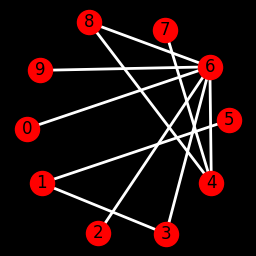

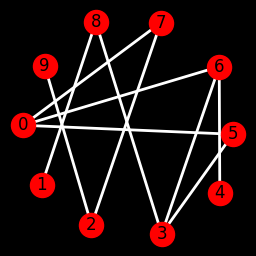

'------rewire 10 mais similares--------'

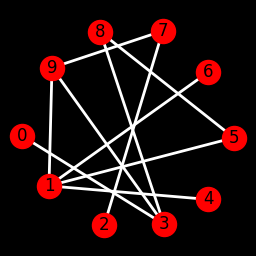

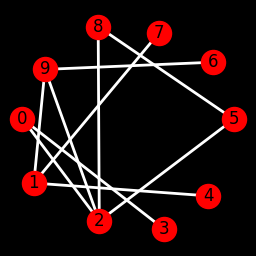

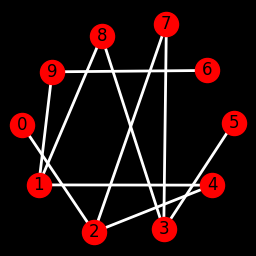

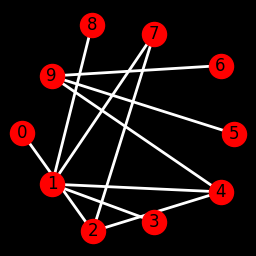

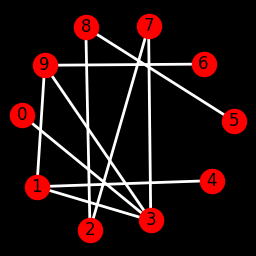

In [29]:
def organize(idx_ref, sims, ds, columns):

    sims_img = sims[idx_ref, columns]
    idx_ord = torch.argsort(sims_img)
    #sims_img_ord = sims_img[idx_ord]
    ds_ord = [ds[columns.start+idx][0] for idx in idx_ord]

    return ds_ord

ds_rewire1_ord = organize(idx_ref, sims_train, ds, slice(0, 56))
ds_rewire2_ord = organize(idx_ref, sims_train, ds, slice(57, 1056))
ds_rewire3_ord = organize(idx_ref, sims_train, ds, slice(1057, 2056))
ds_rewire6_ord = organize(idx_ref, sims_train, ds, slice(2057, 3056))
ds_rewire10_ord = organize(idx_ref, sims_train, ds, slice(3057, 4056))

display("------rewire 1 menos similares--------", *ds_rewire1_ord[:5])
display("------rewire 1 mais similares--------", *ds_rewire1_ord[-5:])
display( "------rewire 2 menos similares--------", *ds_rewire2_ord[:5])
display("------rewire 2 mais similares--------", *ds_rewire2_ord[-5:])
display("------rewire 3 menos similares--------", *ds_rewire3_ord[:5])
display("------rewire 3 mais similares--------", *ds_rewire3_ord[-5:])
display( "------rewire 6 menos similares--------", *ds_rewire6_ord[:5])
display("------rewire 6 mais similares--------", *ds_rewire6_ord[-5:])
display("------rewire 10 menos similares--------", *ds_rewire10_ord[:5])
display("------rewire 10 mais similares--------", *ds_rewire10_ord[-5:])